In [ ]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import json

# Load CSV file
csv_file = "/content/drive/MyDrive/AquaDiva/ENVO.csv"  # Change this to your actual file path
df = pd.read_csv(csv_file)

# Extract relevant columns
ontology_dict = {}
missing_class_label = []
missing_both = []

for index, row in df.iterrows():
    concept = str(row["classLabel"]).strip() if pd.notna(row["classLabel"]) else None
    definition = str(row["classComment"]).strip() if pd.notna(row["classComment"]) else ""

    if concept:  # If classLabel exists, add to dictionary
        ontology_dict[concept] = definition
    else:
        if pd.isna(row["classComment"]):
            missing_both.append(index)  # Row where both are missing
        else:
            missing_class_label.append(index)  # Row where only classLabel is missing

# Save to JSON
output_json = "/content/drive/MyDrive/AquaDiva/ENVO_concepts.json"
with open(output_json, "w", encoding="utf-8") as f:
    json.dump(ontology_dict, f, indent=4, ensure_ascii=False)

# Print missing rows
print(f"✅ Ontology JSON saved as {output_json}")
print(f"⚠️ Rows with missing 'classLabel': {missing_class_label}")
print(f"⚠️ Rows with both 'classLabel' and 'classComment' missing: {missing_both}")


✅ Ontology JSON saved as /content/drive/MyDrive/AquaDiva/ENVO_concepts.json
⚠️ Rows with missing 'classLabel': []
⚠️ Rows with both 'classLabel' and 'classComment' missing: []


In [ ]:
!pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 27.1 MB/s eta 0:00:00


In [ ]:
import json
from sentence_transformers import SentenceTransformer, util
from rapidfuzz import fuzz

# Load Pretrained Sentence Embedding Model
embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
from sklearn.decomposition import PCA

# Load Pretrained Sentence Embedding Model
embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

### 1. Load Ontologies ###
def load_ontology(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        return json.load(f)

# Load LLM-generated ontology
llm_ontology = load_ontology("/content/Experiment6CarbonNitrogen.json")

# Load two domain ontologies
domain_ontology_1 = load_ontology("/content/drive/MyDrive/AquaDiva/ENVO_concepts.json")  # ENVO
domain_ontology_2 = load_ontology("/content/drive/MyDrive/AquaDiva/INBIO_concepts.json")  # INBIO

# Combine both ontologies into one dictionary
combined_domain_ontology = {**domain_ontology_1, **domain_ontology_2}  # Merges both ontologies

### 2. Embed Concepts + Definitions ###
def embed_text(text):
    """Generate an embedding for a given text."""
    return embedding_model.encode(text, convert_to_tensor=True)

# Create embeddings for LLM-generated concepts
llm_embeddings = {concept: embed_text(concept + " - " + definition) for concept, definition in llm_ontology.items()}

# Create embeddings for domain ontologies separately
domain_embeddings_1 = {concept: embed_text(concept + " - " + definition) for concept, definition in domain_ontology_1.items()}
domain_embeddings_2 = {concept: embed_text(concept + " - " + definition) for concept, definition in domain_ontology_2.items()}

### 3. Compare Embeddings & Filter Concepts ###
accepted_matches = []
hallucinated_concepts = []
similarity_threshold = 0.55  # Adjust if needed
matched_in_envo = 0
matched_in_inbio = 0

for llm_concept, llm_emb in llm_embeddings.items():
    best_match = None
    best_score = 0
    best_ontology = None

    # Check in Ontology 1 (ENVO)
    for domain_concept, domain_emb in domain_embeddings_1.items():
        score = util.cos_sim(llm_emb, domain_emb).item()
        if score > best_score:
            best_score = score
            best_match = domain_concept
            best_ontology = "ENVO (Ontology 1)"

    # Check in Ontology 2 (INBIO)
    for domain_concept, domain_emb in domain_embeddings_2.items():
        score = util.cos_sim(llm_emb, domain_emb).item()
        if score > best_score:
            best_score = score
            best_match = domain_concept
            best_ontology = "INBIO (Ontology 2)"

    if best_score >= similarity_threshold:
        accepted_matches.append((llm_concept, best_match, best_ontology, best_score))
        if best_ontology == "ENVO (Ontology 1)":
            matched_in_envo += 1
        elif best_ontology == "INBIO (Ontology 2)":
            matched_in_inbio += 1
        print(f"✅ Keeping '{llm_concept}' (Matched with '{best_match}' in {best_ontology}, Similarity: {best_score:.2f})")
    else:
        hallucinated_concepts.append(llm_concept)
        print(f"❌ Removing '{llm_concept}' (No strong match found, Best Similarity: {best_score:.2f})")

### 4. Print Statistics ###
total_llm_concepts = len(llm_ontology)
matched_concepts = len(accepted_matches)
hallucinated_concepts_count = len(hallucinated_concepts)

percentage_matched = (matched_concepts / total_llm_concepts) * 100
percentage_hallucinated = (hallucinated_concepts_count / total_llm_concepts) * 100

print("\n📊 **Matching Statistics**:")
print(f"✅ Matched Concepts: {matched_concepts} / {total_llm_concepts} ({percentage_matched:.2f}%)")
print(f"❌ Hallucinated Concepts: {hallucinated_concepts_count} / {total_llm_concepts} ({percentage_hallucinated:.2f}%)")
print(f"🌿 Matched in ENVO (Ontology 1): {matched_in_envo}")
print(f"🔬 Matched in INBIO (Ontology 2): {matched_in_inbio}")

### 5. Prepare Data for Plotting ###
llm_emb_list = [llm_embeddings[c1].cpu().numpy() for c1, _, _, _ in accepted_matches]
domain_emb_list = [
    (domain_embeddings_1[c2].cpu().numpy() if best_ontology == "ENVO (Ontology 1)" else domain_embeddings_2[c2].cpu().numpy())
    for _, c2, best_ontology, _ in accepted_matches
]

# Reduce to 2D using PCA
all_embeddings = np.vstack(llm_emb_list + domain_emb_list)
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(all_embeddings)

# Split reduced embeddings into LLM and domain ontology points
llm_points = reduced_embeddings[:len(accepted_matches)]
domain_points = reduced_embeddings[len(accepted_matches):]




✅ Keeping 'CO2FixationPathway' (Matched with 'concentration of carbon dioxide in soil' in ENVO (Ontology 1), Similarity: 0.56)
✅ Keeping 'CarbonCycleProcess' (Matched with 'carbon cycling' in ENVO (Ontology 1), Similarity: 0.73)
✅ Keeping 'NitrogenCycleProcess' (Matched with 'nitrogen compound metabolic process' in ENVO (Ontology 1), Similarity: 0.74)
✅ Keeping 'CarbonFixation' (Matched with 'carbon sequestration process' in ENVO (Ontology 1), Similarity: 0.64)
✅ Keeping 'CarbonSequestration' (Matched with 'biotic carbon sequestration' in ENVO (Ontology 1), Similarity: 0.75)
✅ Keeping 'AmmoniaOxidation' (Matched with 'ammonia oxidation' in ENVO (Ontology 1), Similarity: 0.73)
✅ Keeping 'Denitrification' (Matched with 'nitrate-reducing sediment' in ENVO (Ontology 1), Similarity: 0.64)
✅ Keeping 'NitrogenFixation' (Matched with 'cellular nitrogen compound metabolic process' in ENVO (Ontology 1), Similarity: 0.67)
❌ Removing 'TraceGasProduction' (No strong match found, Best Similarity: 0.

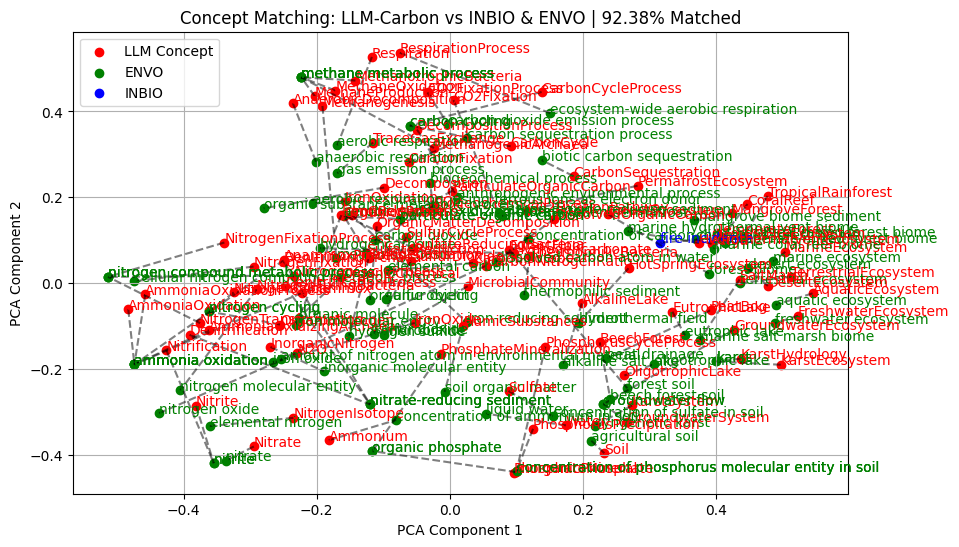

In [ ]:
plt.figure(figsize=(10, 6))

# Scatter plots for the legend (only plotted once to avoid duplication)
plt.scatter([], [], color='red', label="LLM Concept")
plt.scatter([], [], color='green', label="ENVO")
plt.scatter([], [], color='blue', label="INBIO")

# Plot the actual data
for i, (c1, c2, best_ontology, score) in enumerate(accepted_matches):
    color = 'green' if best_ontology == "ENVO (Ontology 1)" else 'blue'  # Green for ENVO, Blue for INBIO

    plt.scatter(llm_points[i, 0], llm_points[i, 1], color='red')  # LLM Concept
    plt.scatter(domain_points[i, 0], domain_points[i, 1], color=color)  # Matched ontology concept
    plt.plot([llm_points[i, 0], domain_points[i, 0]], [llm_points[i, 1], domain_points[i, 1]], 'k--', alpha=0.5)
    plt.text(llm_points[i, 0], llm_points[i, 1], c1, fontsize=10, color='red')
    plt.text(domain_points[i, 0], domain_points[i, 1], c2, fontsize=10, color=color)

# Fix title and labels
plt.legend()
plt.title(f"Concept Matching: LLM-Carbon vs INBIO & ENVO | {percentage_matched:.2f}% Matched")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)

# Save figure
plt.savefig("/content/Carbonconcept_matching_plot.png", dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
hallucinated_concepts

['TraceGasProduction',
 'TraceGasConsumption',
 'Rubisco',
 'CH4',
 'RiparianZone',
 'RootExudation',
 'AcidophilicMicrobes',
 'HalophilicBacteria']

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA

# Load pre-trained embedding model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Function to load JSON file
def load_json(json_path):
    with open(json_path, "r", encoding="utf-8") as f:
        return json.load(f)

# Function to generate embeddings for concepts and definitions
def generate_embeddings(concepts_dict):
    embeddings = {}
    for concept, definition in concepts_dict.items():
        text = f"{concept}: {definition}".strip()
        embeddings[concept] = model.encode(text)
    return embeddings

# Function to compute cosine similarity between concept embeddings
def compute_similarity(embeddings1, embeddings2):
    concepts1 = list(embeddings1.keys())
    concepts2 = list(embeddings2.keys())
    matrix1 = np.array(list(embeddings1.values()))
    matrix2 = np.array(list(embeddings2.values()))
    similarity_matrix = cosine_similarity(matrix1, matrix2)
    return similarity_matrix, concepts1, concepts2

# Function to summarize matching results
def summarize_matches(similarity_matrix, concepts1, concepts2, threshold=0.55):
    matched = 0
    unmatched = []
    matches_per_ontology = {}
    for i, concept in enumerate(concepts1):
        max_sim = max(similarity_matrix[i])
        if max_sim >= threshold:
            matched += 1
            match_index = np.argmax(similarity_matrix[i])
            matched_concept = concepts2[match_index]
            matches_per_ontology[concept] = matched_concept
        else:
            unmatched.append(concept)
    return matched, unmatched, matches_per_ontology

# Function to plot PCA visualization of concept similarity
def plot_pca(embeddings_dict, matches_per_ontology):
    all_concepts = list(embeddings_dict.keys())
    all_embeddings = np.array(list(embeddings_dict.values()))

    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(all_embeddings)

    plt.figure(figsize=(12, 8))

    colors = {"JSON": "red", "ENVO": "green", "OBOE_SBC": "blue"}
    markers = {"JSON": "o", "ENVO": "s", "OBOE_SBC": "^"}

    for i, concept in enumerate(all_concepts):
        category = "JSON" if concept in matches_per_ontology else "ENVO"
        plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], color=colors[category], marker=markers[category], label=concept if category == "JSON" else "")
        plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], concept, fontsize=8, color=colors[category])

    for json_concept, matched_concept in matches_per_ontology.items():
        json_idx = all_concepts.index(json_concept)
        matched_idx = all_concepts.index(matched_concept)
        plt.plot([reduced_embeddings[json_idx, 0], reduced_embeddings[matched_idx, 0]],
                 [reduced_embeddings[json_idx, 1], reduced_embeddings[matched_idx, 1]], "k--", alpha=0.5)

    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("Concept Matching: AquaDivaVersion3 vs ENVO & OBOE_SBC")
    plt.legend(["LLM Concept", "ENVO", "OBOE_SBC"], loc="upper left")
    plt.show()

# Main execution
if __name__ == "__main__":
    json_path = "/content/carbon.json"  # Replace with actual JSON file
    json_concepts = load_json(json_path)

    # Generate embeddings for JSON concepts
    json_embeddings = generate_embeddings(json_concepts)

    # Load ontology concepts (replace with actual ontology data sources)
    ontology_paths = ["/content/envo_classes.json", "/content/oboe_sbc_classes.json"]
    ontology_embeddings = {}
    for path in ontology_paths:
        ontology_data = load_json(path)
        ontology_embeddings[path] = generate_embeddings(ontology_data)

    # Compute similarity and summarize results
    results = []
    all_embeddings_dict = json_embeddings.copy()

    for ontology_name, embeddings in ontology_embeddings.items():
        similarity_matrix, concepts1, concepts2 = compute_similarity(json_embeddings, embeddings)
        matched, unmatched, matches_per_ontology = summarize_matches(similarity_matrix, concepts1, concepts2)
        results.append([ontology_name, matched, len(unmatched)])
        all_embeddings_dict.update(embeddings)

        # Print unmatched concepts
        print(f"\nUnmatched concepts in {ontology_name}:")
        for concept in unmatched:
            print(concept)

    # Convert results to a DataFrame
    df_results = pd.DataFrame(results, columns=["Ontology", "Matched", "Unmatched"])
    print(df_results)





Unmatched concepts in /content/envo_classes.json:
TraceGasProduction
TraceGasConsumption
BeechForest
Rubisco
CH4
DenitrificationProcess
RiparianZone

Unmatched concepts in /content/oboe_sbc_classes.json:
CO2FixationPathway
CarbonSequestration
AmmoniaOxidation
NitrogenFixation
TraceGasProduction
TraceGasConsumption
ForestEcosystem
BeechForest
KarstSystem
MicrobialCommunity
Rubisco
CO2
CH4
N2O
Soil
BiogeochemicalProcess
MarineEcosystem
TropicalRainforest
Taiga
DecompositionProcess
CarbonCycle
CO2FixationProcess
NitrogenFixationProcess
DenitrificationProcess
AmmoniaOxidationProcess
TraceGasExchange
DesertEcosystem
KarstHydrology
Anammox
Methanogenesis
MethaneOxidation
OrganicMatterDecomposition
PermafrostEcosystem
ForestFireEcosystem
Hydrogencarbonate
CO2Fixation
AnammoxProcess
MethaneProduction
RiparianZone
Decomposition
ForestFloor
RootExudation
AnaerobicDecomposition
NitrogenFixingBacteria
AmmoniaOxidizingArchaea
SulfateReducingBacteria
MethanotrophicBacteria
MethanogenicArchaea
Denit

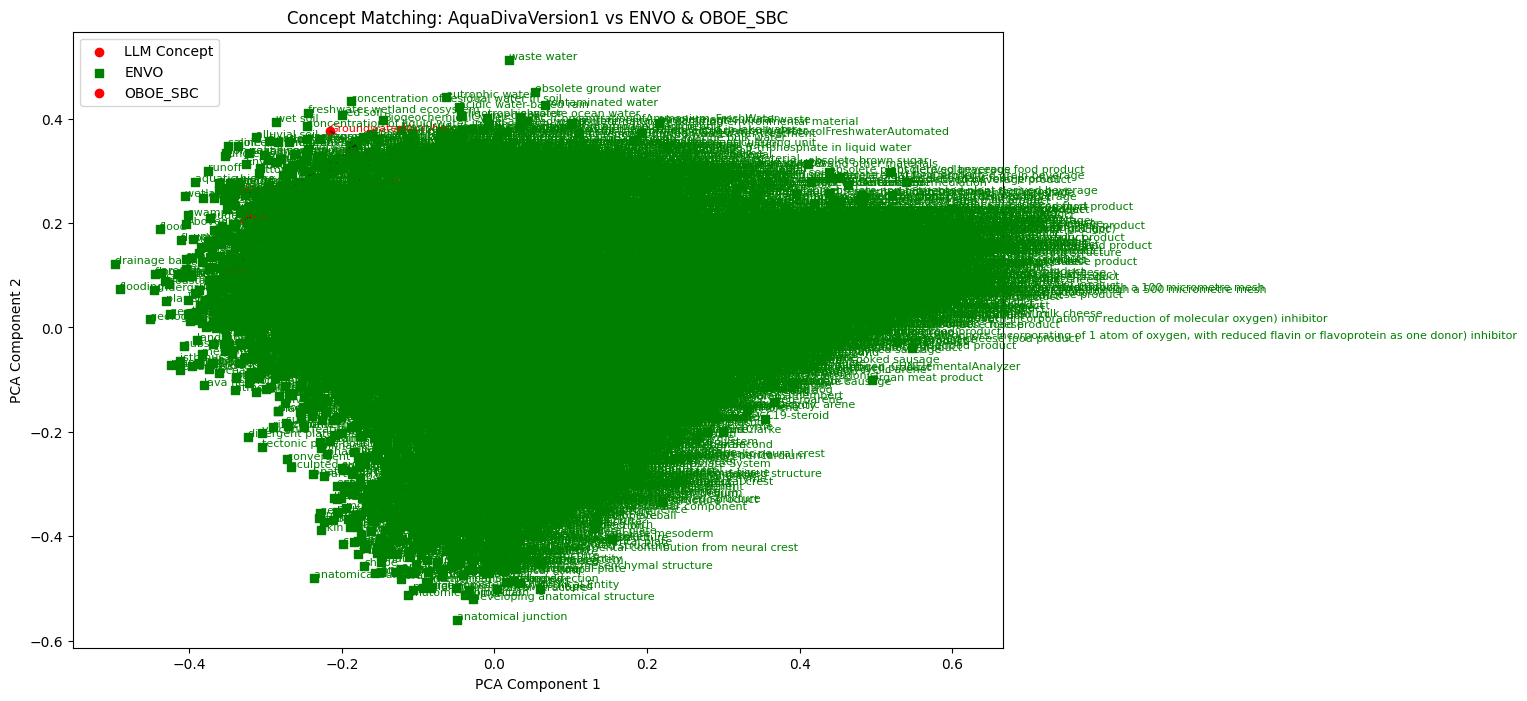

In [ ]:
# Generate PCA plot
plot_pca(all_embeddings_dict, matches_per_ontology)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import json
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
def load_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return json.load(f)

def compute_embeddings(concepts, model, tokenizer):
    texts = [f"{concept} {tokenizer.sep_token} {definition}" for concept, definition in concepts.items()]
    return model.encode(texts, convert_to_numpy=True)

def match_concepts(llm_concepts, domain_ontologies, model, tokenizer, threshold=0.55):
    total_llm_concepts = len(llm_concepts)
    unmatched_concepts = llm_concepts.copy()
    print(f"Total LLM Concepts: {len(unmatched_concepts)}")
    matched_results = []
    summary_results = []

    for i, (ontology_name, domain_concepts) in enumerate(domain_ontologies.items()):
        print(f"Processing {ontology_name}...")

        llm_embeddings = compute_embeddings(unmatched_concepts, model, tokenizer)
        domain_embeddings = compute_embeddings(domain_concepts, model, tokenizer)

        similarities = cosine_similarity(llm_embeddings, domain_embeddings)
        matched_indices = np.where(similarities >= threshold)

        matched_concepts = {}
        for llm_idx, domain_idx in zip(*matched_indices):
            llm_concept = list(unmatched_concepts.keys())[llm_idx]
            domain_concept = list(domain_concepts.keys())[domain_idx]
            matched_concepts[llm_concept] = domain_concept
            matched_results.append(f"{llm_concept} -> {domain_concept} ({ontology_name})")

        # Remove matched concepts from unmatched list
        unmatched_concepts = {k: v for k, v in unmatched_concepts.items() if k not in matched_concepts}
        matched_percentage = ((total_llm_concepts- len(unmatched_concepts)) * 100 ) / total_llm_concepts

        unmatched_list = list(unmatched_concepts.keys())
        summary_results.append((ontology_name, matched_percentage, unmatched_list))

        # Save unmatched concepts after each ontology match
        unmatched_df = pd.DataFrame({"Unmatched Concepts": unmatched_list})
        unmatched_csv = f"unmatched_concepts_after_{ontology_name}.csv"
        unmatched_df.to_csv(unmatched_csv, index=False)
        print(f"Unmatched concepts after {ontology_name} saved to {unmatched_csv}")


    return summary_results, unmatched_concepts, matched_results

def save_matched_results(matched_results, file_path='matched_concepts.txt'):
    with open(file_path, 'w', encoding='utf-8') as f:
        for line in matched_results:
            f.write(line + "\n")
    print(f"Matched concepts saved to {file_path}")

def main(llm_file, ontology_files):
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    tokenizer = model.tokenizer
    llm_concepts = load_json(llm_file)
    domain_ontologies = {f'Ontology {i+1}': load_json(file) for i, file in enumerate(ontology_files)}

    summary_results, unmatched_concepts, matched_results = match_concepts(llm_concepts, domain_ontologies, model, tokenizer)
    save_matched_results(matched_results)

    # Display results in a dataframe
    df = pd.DataFrame(summary_results, columns=["Ontology", "% of Matched Concepts", "Unmatched Concepts"])
    print(df)  # Display in console
    df.to_csv("semantic_matching_results.csv", index=False)  # Save results to a CSV file
    df.to_csv("/content/drive/MyDrive/AquaDiva/LLMConcepts/AquaDivaOntologyVersion1_semantic_matching_results.csv", index=False)  # Save results to a CSV file
    print("Results saved to semantic_matching_results.csv")
    print("Processing complete!")


    llm_file = '/content/drive/MyDrive/AquaDiva/LLMConcepts/AquaDivaOntologyVersion1.json'
#ontology_files = ['/content/drive/MyDrive/AquaDiva/BioPortalConcepts/oboe_sbc_classes.json', '/content/drive/MyDrive/AquaDiva/BioPortalConcepts/envo_classes.json', '/content/drive/MyDrive/AquaDiva/BioPortalConcepts/chebi_classes.json']
    ontology_files = ['/content/drive/MyDrive/AquaDiva/BioPortalConcepts/oboe_sbc_classes.json', '/content/drive/MyDrive/AquaDiva/BioPortalConcepts/envo_classes.json', '/content/drive/MyDrive/AquaDiva/BioPortalConcepts/chebi_classes.json']

    main(llm_file, ontology_files)


In [ ]:
llm_file = '/content/drive/MyDrive/AquaDiva/LLMConcepts/AquaDivaOntologyVersion1.json'
#ontology_files = ['/content/drive/MyDrive/AquaDiva/BioPortalConcepts/oboe_sbc_classes.json', '/content/drive/MyDrive/AquaDiva/BioPortalConcepts/envo_classes.json', '/content/drive/MyDrive/AquaDiva/BioPortalConcepts/chebi_classes.json']
ontology_files = ['/content/drive/MyDrive/AquaDiva/BioPortalConcepts/oboe_sbc_classes.json', '/content/drive/MyDrive/AquaDiva/BioPortalConcepts/envo_classes.json', '/content/drive/MyDrive/AquaDiva/BioPortalConcepts/chebi_classes.json']

main(llm_file, ontology_files)


Total LLM Concepts: 67
Processing Ontology 1...
Unmatched concepts after Ontology 1 saved to unmatched_concepts_after_Ontology 1.csv
Processing Ontology 2...
Unmatched concepts after Ontology 2 saved to unmatched_concepts_after_Ontology 2.csv
Processing Ontology 3...
Unmatched concepts after Ontology 3 saved to unmatched_concepts_after_Ontology 3.csv
Matched concepts saved to matched_concepts.txt
     Ontology  % of Matched Concepts  \
0  Ontology 1              46.268657   
1  Ontology 2              91.044776   
2  Ontology 3              94.029851   

                                  Unmatched Concepts  
0  [Microbial Functional Guild, Aquatic Fungi, Aq...  
1  [Strata Continuity, Surface Chemical Signal, C...  
2  [Strata Continuity, Surface Chemical Signal, C...  
Results saved to semantic_matching_results.csv
Processing complete!


In [ ]:
print("hh")

hh


In [1]:
from sentence_transformers import SentenceTransformer, util

# Load the pre-trained model
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Define two ontology triples
#triple1 = "KarstGroundwater is a Water"
#triple2 = "freshwater subclass of water"
triple1 = "TraceGas is_consumed_by MicrobialCommunity"
triple2 = "methane has role bacterial metabolite"
# Convert triples to embeddings
embedding1 = model.encode(triple1, convert_to_tensor=True)
embedding2 = model.encode(triple2, convert_to_tensor=True)

# Compute cosine similarity
similarity_score = util.cos_sim(embedding1, embedding2).item()

# Print similarity score
print(f"Similarity between triples: {similarity_score:.4f}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Similarity between triples: 0.4844


In [4]:
triple1 = "{TraceGas} {is_consumed_by} {MicrobialCommunity}"
triple2 = "{methane} {has role} {bacterial metabolite}"
# Convert triples to embeddings
embedding1 = model.encode(triple1, convert_to_tensor=True)
embedding2 = model.encode(triple2, convert_to_tensor=True)

# Compute cosine similarity
similarity_score = util.cos_sim(embedding1, embedding2).item()

# Print similarity score
print(f"Similarity between triples: {similarity_score:.4f}")

Similarity between triples: 0.5293


In [3]:
triple1 = "{KarstGroundwater} {is a} {Water}"
triple2 = "{freshwater} {subclass of} {water}"
# Convert triples to embeddings
embedding1 = model.encode(triple1, convert_to_tensor=True)
embedding2 = model.encode(triple2, convert_to_tensor=True)

# Compute cosine similarity
similarity_score = util.cos_sim(embedding1, embedding2).item()

# Print similarity score
print(f"Similarity between triples: {similarity_score:.4f}")

Similarity between triples: 0.5810
